In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  

In [8]:
# load calibration error
DATAPATH = '../output_from_datalab/accuracy_estimation_error'
PSEUDOCOUNT = [0.1, 1, 10]
NUM_RUNS = 100
DATASET_LIST = ['imagenet', 'dbpedia', 'cifar100', '20newsgroup', 'svhn', 'imagenet2_topimages'] 
METRIC_LIST = ['weighted_pool_error', 'weighted_online_error', 'unweighted_error', 'pool_ece', 'online_ece', 'mce']

def get_metric_filename(metric, dataset, pseudo_n, model_type):
    return "%s/%s_%s_PseudoCount%.1f_runs%d_%s.csv" % (
                DATAPATH, metric, dataset, pseudo_n, NUM_RUNS, model_type)

In [9]:
N_list = [10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000]
header = ['dataset', 'metric', 'model_type', 'pseudo_n'] + N_list
results = []

In [10]:
for metric in METRIC_LIST:
    for dataset in DATASET_LIST:
        for pseudo_n in PSEUDOCOUNT:
            params = [dataset, pseudo_n]
            bayesian_result = np.mean(np.genfromtxt(get_metric_filename(metric, dataset, pseudo_n, 'bayesian')
                                                    , delimiter=","), axis=0).tolist()
            frequentist_result = np.mean(np.genfromtxt(get_metric_filename(metric, dataset, pseudo_n, 'frequentist')
                                                       , delimiter=","), axis=0).tolist()
            if len(bayesian_result) < len(N_list):
                bayesian_result.append(-1)
                frequentist_result.append(-1)
            results.append([dataset, metric, 'bayesian', pseudo_n] + bayesian_result)
        results.append([dataset, metric, 'frequentist', 0] + frequentist_result)

In [11]:
results =  pd.DataFrame(results, columns=header)
results.to_csv('../output_from_datalab/results.csv')

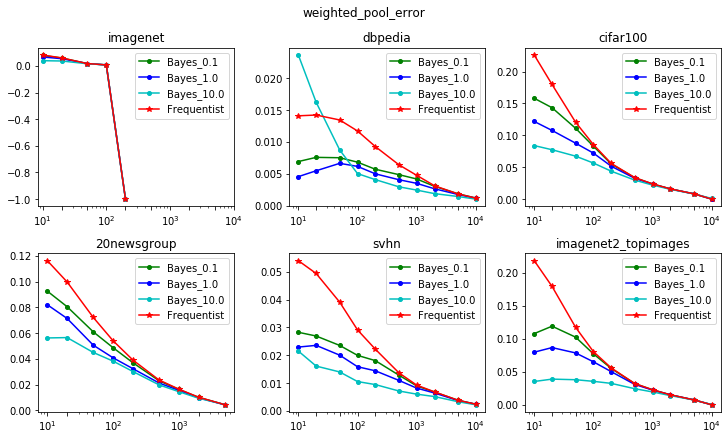

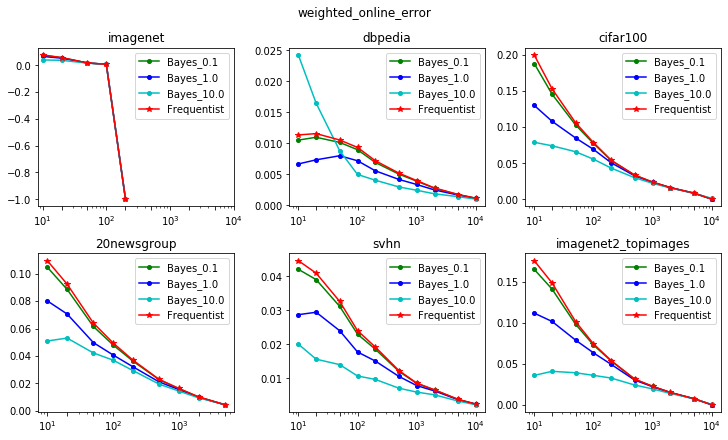

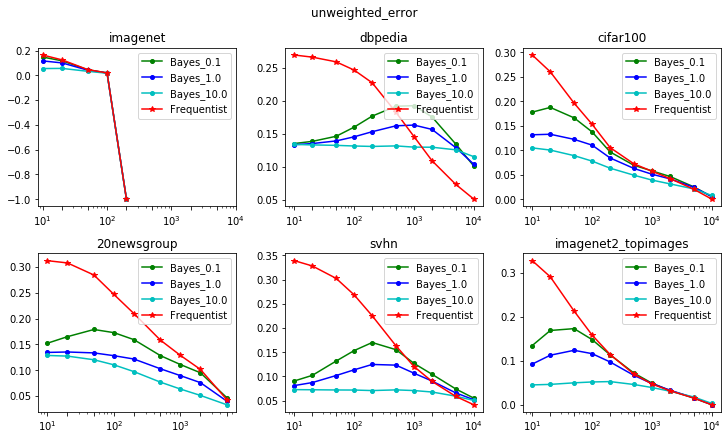

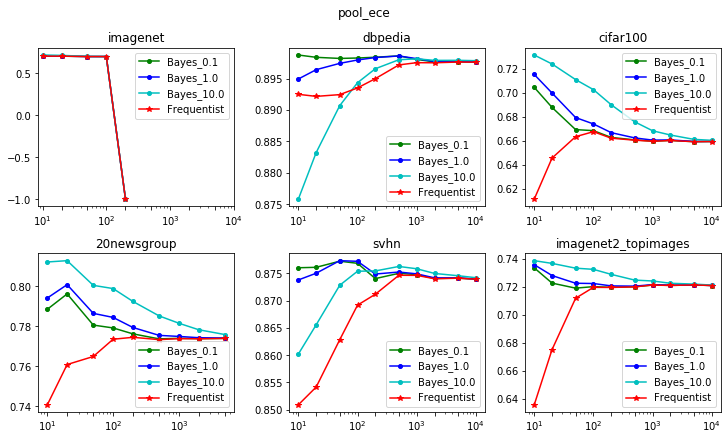

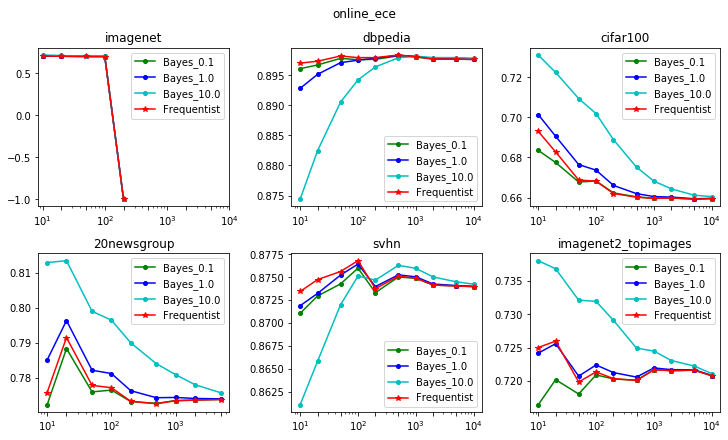

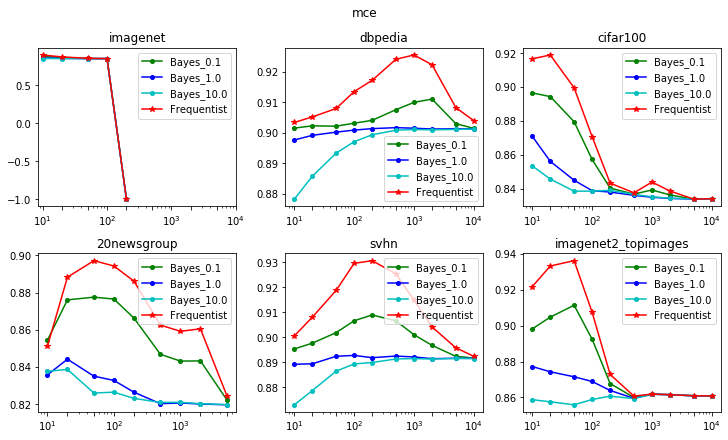

In [12]:
for metric in METRIC_LIST:
    figname = '../figures/accuracy_estimation_error/%s.pdf' % metric
    fig, ax = plt.subplots(2, 3, figsize=(10, 6), constrained_layout=True)
    for idx, dataset in enumerate(DATASET_LIST):
        ax[idx//3, idx% 3].set_title('%s' % dataset)
        if dataset == '20newsgroup':
            x = N_list[:-1]
        else:
            x = N_list
        result_slice = results[(results.metric == metric) & (results.dataset == dataset)]
        y_frequentist = result_slice[result_slice.model_type == 'frequentist'][x].values[0]
        result_slice = result_slice[result_slice.model_type == 'bayesian']
        y_bayesian_01 = result_slice[result_slice.pseudo_n == 0.1][x].values[0]
        y_bayesian_1 = result_slice[result_slice.pseudo_n == 1.0][x].values[0]
        y_bayesian_10 = result_slice[result_slice.pseudo_n == 10.0][x].values[0]
        ax[idx//3, idx% 3].semilogx(x, y_bayesian_01, 'o', ls='-', ms=4, color = 'g', label='Bayes_0.1')
        ax[idx//3, idx% 3].semilogx(x, y_bayesian_1, 'o', ls='-', ms=4, color = 'b', label='Bayes_1.0')
        ax[idx//3, idx% 3].semilogx(x, y_bayesian_10, 'o', ls='-', ms=4, color = 'c', label='Bayes_10.0')
        ax[idx//3, idx% 3].semilogx(x, y_frequentist, '*', ls='-', ms=6, color = 'r', label='Frequentist')
        ax[idx//3, idx% 3].set_xticks(x)
        ax[idx//3, idx% 3].legend()
    plt.suptitle(metric)
    fig.savefig(figname)

In [7]:
metric = 'mce'
for idx, dataset in enumerate(['cifar100']):
    print("========%s======", dataset)
    x = N_list
    result_slice = results[(results.metric == metric) & (results.dataset == dataset)]
    print(result_slice)
    y_frequentist = result_slice[result_slice.model_type == 'frequentist'][x].values[0]
    result_slice = result_slice[result_slice.model_type == 'bayesian']
    y_bayesian_01 = result_slice[result_slice.pseudo_n == 0.1][x].values[0]
    y_bayesian_1 = result_slice[result_slice.pseudo_n == 1.0][x].values[0]
    y_bayesian_10 = result_slice[result_slice.pseudo_n == 10.0][x].values[0]
    print('ground truth MCE:', )

========%s====== cifar100
      dataset metric   model_type  pseudo_n        10        20        50  \
128  cifar100    mce     bayesian       0.1  0.896563  0.894376  0.879574   
129  cifar100    mce     bayesian       1.0  0.870960  0.856222  0.845069   
130  cifar100    mce     bayesian      10.0  0.853557  0.845772  0.838641   
131  cifar100    mce  frequentist       0.0  0.916671  0.918884  0.899575   

          100       200       500      1000      2000      5000     10000  
128  0.857319  0.840458  0.836905  0.839361  0.836431  0.833949  0.834223  
129  0.838943  0.838104  0.836209  0.835045  0.834375  0.833956  0.834226  
130  0.838663  0.839128  0.836765  0.835343  0.834531  0.834020  0.834258  
131  0.870774  0.843358  0.837671  0.843994  0.838747  0.833949  0.834223  
ground truth MCE:


In [177]:
0.837671 / 0.834223 

1.004133187409122